In [1]:
from typing_extensions import TypedDict,Annotated
from typing import List
import os
import re
import operator
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from langchain_community.utilities import SQLDatabase

from dotenv import load_dotenv
load_dotenv()


True

In [2]:
### Configuration

LLM_MODEL = "qwen3"
# LLM_MODEL = "gpt-oss"
BASE_URL = "http://localhost:11434"
llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL, reasoning=True)

response = llm.invoke("Hello, how are you?")
response.pretty_print()

================================== Ai Message ==================================

Hello! I'm just a chatbot, so I don't have feelings, but I'm here and ready to help! 😊 How can I assist you today? Whether you have questions, need recommendations, or just want to chat, I'm happy to help! What's on your mind?


In [3]:
response

AIMessage(content="Hello! I'm just a chatbot, so I don't have feelings, but I'm here and ready to help! 😊 How can I assist you today? Whether you have questions, need recommendations, or just want to chat, I'm happy to help! What's on your mind?", additional_kwargs={'reasoning_content': 'Okay, the user greeted me with "Hello, how are you?" I need to respond in a friendly and natural way. Let me start by acknowledging their greeting. I should mention that I\'m just a chatbot, so I don\'t have feelings, but I\'m here to help. Maybe add a bit of personality to keep it engaging. Let me check if there\'s anything else I should include. Oh, right, I should invite them to ask questions or share topics they\'re interested in. Keep it simple and conversational. Alright, that should work.\n'}, response_metadata={'model': 'qwen3', 'created_at': '2026-01-27T21:51:14.75288Z', 'done': True, 'done_reason': 'stop', 'total_duration': 31890259791, 'load_duration': 12688645166, 'prompt_eval_count': 16, '

In [4]:
response.additional_kwargs

{'reasoning_content': 'Okay, the user greeted me with "Hello, how are you?" I need to respond in a friendly and natural way. Let me start by acknowledging their greeting. I should mention that I\'m just a chatbot, so I don\'t have feelings, but I\'m here to help. Maybe add a bit of personality to keep it engaging. Let me check if there\'s anything else I should include. Oh, right, I should invite them to ask questions or share topics they\'re interested in. Keep it simple and conversational. Alright, that should work.\n'}

In [5]:
### Database setup

db = SQLDatabase.from_uri('sqlite:///db/employees_db-full-1.0.6.db')

tables = db.get_usable_table_names()
tables


SCHEMA = db.get_table_info()

In [6]:
# print(SCHEMA)

In [7]:
### SQL TOOLS

@tool
def get_database_schema(table_name:str = None):
    """Get database schema information for SQL query generation.
    Use this first to understand table structure before creating queries."""

    if table_name:
        tables = db.get_usable_table_names()
        if table_name.lower() in [t.lower() for t in tables]:
            result = db.get_table_info([table_name])
            return result
        else:
            return f"Error: Table '{table_name}' not found . Available tables : '{', '.join(tables)}'"
    else:
        return SCHEMA

In [8]:
get_database_schema.invoke('mnb')

"Error: Table 'mnb' not found . Available tables : 'departments, dept_emp, dept_manager, employees, salaries, titles'"

In [9]:
@tool
def generate_sql_query(question: str, schema_info: str = None):
    """Generate a SQL SELECT query from a natural language question using database schema.
    Always use this after getting schema information."""
    schema_to_use = schema_info if schema_info else SCHEMA

    prompt = f"""Based on this database schema:
                {schema_to_use}

                Generate a SQL query to answer this question: {question}

                Rules:
                - Use only SELECT statements
                - Include only existing columns and tables
                - Add appropriate WHERE, GROUP BY, ORDER BY clauses as needed
                - Limit results to 10 rows unless specified otherwise
                - Use proper SQL syntax for SQLite

                Return only the SQL query, nothing else."""
    response = llm.invoke(prompt)
    sql_query = response.content.strip()
    print(f"[TOOL] Generated SQL Query: {sql_query[:30]}...")
    return sql_query


In [10]:
generate_sql_query.invoke("How many employees are there?")


[TOOL] Generated SQL Query: SELECT COUNT(*) FROM employees...


'SELECT COUNT(*) FROM employees;'

In [11]:
@tool
def validate_sql_query(query: str):
    """Validate SQL query for safety and syntax before execution.
        Returns 'Valid: <query>' if safe or 'Error: <message>' if unsafe."""
    
    clean_query = query.strip()

    # remove SQL code block
    clean_query = re.sub(r'```sql\s*','',clean_query, flags=re.IGNORECASE)
    clean_query = re.sub(r'```\s*','',clean_query, flags=re.IGNORECASE)

    clean_query = clean_query.strip().rstrip(';')

    if not clean_query.lower().startswith('select'):
        return "Error: only select statements are allowed"
    
    dangerous_keywords = ['INSERT', 'UPDATE', 'DELETE', 'ALTER', 'DROP', 'CREATE', 'TRUNCATE']
    query_upper = clean_query
    
    for keyword in dangerous_keywords:
        if keyword in query_upper:
            return f"Error: {keyword} operations are not allowed."
        
    print("[TOOL] Your SQL query is validated. Passed!")
    return clean_query


In [12]:
validate_sql_query.invoke('SELECT COUNT(*) FROM employees;')

[TOOL] Your SQL query is validated. Passed!


'SELECT COUNT(*) FROM employees'

In [13]:
@tool
def execute_sql_query(sql_query: str):
    """Execute a validated SQL query and return results.
    Only use this after validating the query for safety."""

    query = validate_sql_query.invoke(sql_query)

    if query.startswith('Error:'):
        return f"Query '{sql_query}' validation failed with Error: {query} "
    
    result = db.run(query)

    if result:
        return f"Query result: {result}"
    else:
        return f"Query executed successfully but No result was found!"

In [14]:
execute_sql_query.invoke('SELECT COUNT(*) FROM employees;')

[TOOL] Your SQL query is validated. Passed!


'Query result: [(300024,)]'

In [15]:
@tool
def fix_sql_error(original_query:str, error_message: str, question):
    """Fix a failed SQL query by analyzing the error and generating a corrected version.
        Use this when validation or execution fails."""

    fix_prompt = f"""The following SQL query failed:
                    Query: {original_query}
                    Error: {error_message}
                    Original Question: {question}

                    Database Schema:
                    {SCHEMA}

                    Analyze the error and provide a corrected SQL query that:
                    1. Fixes the specific error mentioned
                    2. Still answers the original question
                    3. Uses only valid table and column names from the schema
                    4. Follows SQLite syntax rules

                    Return only the corrected SQL query, nothing else."""
    response = llm.invoke(fix_prompt)
    query = response.content.strip()

    print("[TOOL] Generated fixed SQL query.")

    return query

### MySQL Agent Creation

In [16]:
class AgentState(TypedDict):
    messages : Annotated[list, operator.add]

tools =[
    get_database_schema,
    generate_sql_query,
    execute_sql_query,
    fix_sql_error
] 

llm_with_tools = llm.bind_tools(tools)

In [17]:
llm_with_tools

RunnableBinding(bound=ChatOllama(model='qwen3', reasoning=True, base_url='http://localhost:11434'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_database_schema', 'description': 'Get database schema information for SQL query generation.\n    Use this first to understand table structure before creating queries.', 'parameters': {'properties': {'table_name': {'default': None, 'type': 'string'}}, 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'generate_sql_query', 'description': 'Generate a SQL SELECT query from a natural language question using database schema.\n    Always use this after getting schema information.', 'parameters': {'properties': {'question': {'type': 'string'}, 'schema_info': {'default': None, 'type': 'string'}}, 'required': ['question'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'execute_sql_query', 'description': 'Execute a validated SQL query and return results.\n    Only use this after validating the query for s

In [18]:
## Langgraph Agent nodes

def agent_node(state: AgentState):
    system_prompt = f"""You are an expert SQL analyst working with an employees database.

                    Database Schema:
                    {SCHEMA}

                    Your workflow for answering questions:
                    1. Use `get_database_schema` first to understand available tables and columns (if needed)
                    2. Use `generate_sql_query` to create SQL based on the question
                    3. Use `execute_sql_query` to run the validated query
                    4. If there's an error, use `fix_sql_error` to correct it and try again (up to 3 times)

                    Rules:
                    - Always follow the workflow step by step
                    - If a query fails, use the fix tool and try again
                    - Provide clear, informative answers
                    - Be precise with table and column names
                    - Handle errors gracefully and try to fix them
                    - If you fail after 3 attempts, explain what went wrong

                    Available tools:
                    - get_database_schema: Get table structure info
                    - generate_sql_query: Create SQL from question
                    - execute_sql_query: Run the query
                    - fix_sql_error: Fix failed queries

                    Remember: Always validate queries before executing them for safety."""
    
    messages = [SystemMessage(system_prompt)] + state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [19]:
llm_with_tools.invoke('how many employees are there')

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "how many employees are there". I need to figure out how to answer this using the tools provided. Let me start by recalling the available functions.\n\nFirst, the user\'s question is a natural language query that requires a SQL query to get the count of employees. The tools mention that I should first get the database schema to understand the table structure. So the first step is to call the get_database_schema function. \n\nWait, but the user is asking about employees. There\'s a possibility that the database has a table named \'employees\' or maybe another table that contains employee information. Without knowing the schema, I can\'t be sure. So I need to retrieve the schema first. However, looking at the function definition for get_database_schema, the parameters seem to be empty. The function might not require any arguments, just execute and return the schema information. \n\nOnce I have the sch

In [20]:
### Router Logic

def should_continue(state: AgentState):
    last_message = state['messages'][-1]

    if hasattr(last_message,'tool_calls') and last_message.tool_calls:
        print("[ROUTER] Calling the tool")
        for tc in last_message.tool_calls:
            print(f"Calling tool: '{tc['name']}' with Args: '{tc['args']}'")
        return 'tools'
    else:
        print("[AGENT] Agent is processing your request...")
        return END

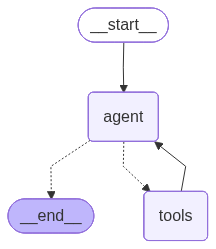

In [21]:
### Build Graph

def create_sql_agent():

    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('agent', agent_node)
    builder.add_node('tools', ToolNode(tools))

    # add edges
    builder.add_edge(START, 'agent')
    builder.add_edge('tools', 'agent')

    # add router
    builder.add_conditional_edges('agent', should_continue,['tools',END])

    graph = builder.compile()

    return graph


agent = create_sql_agent()
agent

In [22]:
query = "how many employees are there"
result = agent.invoke({'messages':[query]})

[ROUTER] Calling the tool
Calling tool: 'get_database_schema' with Args: '{'table_name': 'employees'}'
[ROUTER] Calling the tool
Calling tool: 'generate_sql_query' with Args: '{'question': 'how many employees are there', 'schema_info': 'CREATE TABLE employees ( emp_no INTEGER NOT NULL, birth_date DATE NOT NULL, first_name VARCHAR(14) NOT NULL, last_name VARCHAR(16) NOT NULL, gender TEXT NOT NULL, hire_date DATE NOT NULL, PRIMARY KEY (emp_no) )'}'
[TOOL] Generated SQL Query: SELECT COUNT(*) FROM employees...
[ROUTER] Calling the tool
Calling tool: 'execute_sql_query' with Args: '{'sql_query': 'SELECT COUNT(*) FROM employees;'}'
[TOOL] Your SQL query is validated. Passed!
[AGENT] Agent is processing your request...


In [23]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

The total number of employees in the database is **300,024**.

This was determined by executing the query:
```sql
SELECT COUNT(*) FROM employees;
```

The result indicates there are 300,024 records in the `employees` table.


In [24]:
query = "What is the average salary of each department"
result = agent.invoke({'messages':[query]})
result['messages'][-1].pretty_print()

[ROUTER] Calling the tool
Calling tool: 'generate_sql_query' with Args: '{'question': 'What is the average salary of each department', 'schema_info': 'CREATE TABLE departments (\n\tdept_no CHAR(4) NOT NULL, \n\tdept_name VARCHAR(40) NOT NULL, \n\tPRIMARY KEY (dept_no), \n\tUNIQUE (dept_name)\n)\n\nCREATE TABLE dept_emp (\n\temp_no INTEGER NOT NULL, \n\tdept_no CHAR(4) NOT NULL, \n\tfrom_date DATE NOT NULL, \n\tto_date DATE NOT NULL, \n\tPRIMARY KEY (emp_no, dept_no), \n\tFOREIGN KEY(dept_no) REFERENCES departments (dept_no), \n\tFOREIGN KEY(emp_no) REFERENCES employees (emp_no)\n)\n\nCREATE TABLE dept_manager (\n\tdept_no CHAR(4) NOT NULL, \n\temp_no INTEGER NOT NULL, \n\tfrom_date DATE NOT NULL, \n\tto_date DATE NOT NULL, \n\tPRIMARY KEY (emp_no, dept_no), \n\tFOREIGN KEY(dept_no) REFERENCES departments (dept_no), \n\tFOREIGN KEY(emp_no) REFERENCES employees (emp_no)\n)\n\nCREATE TABLE employees (\n\temp_no INTEGER NOT NULL, \n\tbirth_date DATE NOT NULL, \n\tfirst_name VARCHAR(14) NOT

In [25]:
query = "What is the average salary of each department. Show me top 5 department."
result = agent.invoke({'messages':[query]})
result['messages'][-1].pretty_print()

[ROUTER] Calling the tool
Calling tool: 'generate_sql_query' with Args: '{'question': 'What is the average salary of each department. Show me top 5 department.', 'schema_info': '{"departments":{"columns":[{"name":"dept_no","type":"CHAR(4)"},{"name":"dept_name","type":"VARCHAR(40)"}],"primary_key":"dept_no","foreign_keys":[]},"dept_emp":{"columns":[{"name":"emp_no","type":"INTEGER"},{"name":"dept_no","type":"CHAR(4)"},{"name":"from_date","type":"DATE"},{"name":"to_date","type":"DATE"}],"primary_key":["emp_no","dept_no"],"foreign_keys":[{"reference":"departments.dept_no"},{"reference":"employees.emp_no"}]},"dept_manager":{"columns":[{"name":"dept_no","type":"CHAR(4)"},{"name":"emp_no","type":"INTEGER"},{"name":"from_date","type":"DATE"},{"name":"to_date","type":"DATE"}],"primary_key":["emp_no","dept_no"],"foreign_keys":[{"reference":"departments.dept_no"},{"reference":"employees.emp_no"}]},"employees":{"columns":[{"name":"emp_no","type":"INTEGER"},{"name":"birth_date","type":"DATE"},{"na

In [26]:
query = "Show me the top 5 highest paid employees with their title and salaries"
result = agent.invoke({'messages':[query]})
result['messages'][-1].pretty_print()

[ROUTER] Calling the tool
Calling tool: 'generate_sql_query' with Args: '{'question': 'Show me the top 5 highest paid employees with their title and salaries', 'schema_info': 'departments, dept_emp, dept_manager, employees, salaries, titles'}'
[TOOL] Generated SQL Query: SELECT e.emp_no, t.title, s.sa...
[ROUTER] Calling the tool
Calling tool: 'execute_sql_query' with Args: '{'sql_query': 'SELECT e.emp_no, t.title, s.salary FROM employees e JOIN titles t ON e.emp_no = t.emp_no JOIN salaries s ON e.emp_no = s.emp_no ORDER BY s.salary DESC LIMIT 5;'}'
[TOOL] Your SQL query is validated. Passed!
[AGENT] Agent is processing your request...
================================== Ai Message ==================================

Here are the top 5 highest paid employees with their current titles and salaries:

1. **Employee 43624** - Senior Staff: $158,220  
2. **Employee 43624** - Staff: $158,220  
3. **Employee 43624** - Senior Staff: $157,821  
4. **Employee 43624** - Staff: $157,821  
5. **Empl